# Solar and Wind Utilities

The data this week comes from the [Berkeley Lab](https://emp.lbl.gov/utility-scale-solar). See the technical brief on the [emp.lbl.gov site](https://emp.lbl.gov/sites/default/files/utility-scale_solar_2021_technical_brief.pdf).

> Berkeley Lab’s “Utility-Scale Solar, 2021 Edition” presents analysis of empirical plant-level data from the U.S. fleet of ground-mounted photovoltaic (PV), PV+battery, and concentrating solar-thermal power (CSP) plants with capacities exceeding 5 MWAC. While focused on key developments in 2020, this report explores trends in deployment, technology, capital and operating costs, capacity factors, the levelized cost of solar energy (LCOE), power purchase agreement (PPA) prices, and wholesale market value.

In [1]:
library(tidyverse)
library(paletteer)
library(mice)
library(showtext)
library(patchwork)
library(naniar)
library(tidytext)
library(reshape2)
library(ggrepel)
library(ggtext)
library(lubridate)

library(repr)
options(repr.plot.width = 20.0, repr.plot.height = 13.3)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: sysfonts

Loading required package: showtextdb


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
capacity <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-05-03/capacity.csv')
wind <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-05-03/wind.csv')
solar <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-05-03/solar.csv')
average_cost <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-05-03/average_cost.csv')

Rows: 49 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): type
dbl (6): year, standalone_prior, hybrid_prior, standalone_new, hybrid_new, t...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 328 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): wind_mwh, wind_capacity
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 328 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): solar_mwh, solar_capacity
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this 

We will analyze the files one by one.

In [3]:
font_add_google('Lora', 'lora')
font_add_google('Lobster', 'lobster')
font_add_google('Anton', 'anton')
font_add_google('Fira Sans', 'firasans')
font_add_google('Syne Mono', 'syne')

# Important step to enable showtext font rendering!
showtext_auto()

In [4]:
my_theme <- function() {
  
  # Colors
  color.background = "#F5F5F5"
  color.text = "#030303"
  
  # Begin construction of chart
  theme_bw(base_size=15) +
    
    # Format background colors
    theme(panel.background = element_rect(fill=color.background, color=color.background)) +
    theme(plot.background  = element_rect(fill=color.background, color=color.background)) +
    theme(panel.border     = element_rect(color=color.background)) +
    theme(strip.background = element_rect(fill=color.background, color=color.background)) +
    
    # Format the grid
    theme(panel.grid.major.y = element_blank()) +
    theme(panel.grid.minor.y = element_blank()) +
    theme(panel.grid.major.x = element_blank())+
    theme(panel.grid.minor.x = element_blank()) +
    theme(axis.ticks       = element_blank()) +
    
    # Format the legend
    theme(legend.position = "top") +
    theme(legend.background = element_rect(fill=color.background, color=color.background))+
    theme(legend.text = element_text(size = 25, face = "bold", color=color.text))+
    theme(legend.justification = "center")+
    theme(legend.title = element_text(family = "firasans",
                                    color = "#FFFFFF",
                                    size = 25, face = "bold"))+
    
    
    # Format title and axis labels
    theme(plot.title       = element_text(color=color.text, size=40, face = "bold", hjust = 0.5, family = 'firasans'))+
    theme(plot.subtitle    = element_text(color=color.text, size=30, face = "bold", hjust = 0.5, family = 'firasans'))+
    theme(plot.caption     = element_text(color=color.text, size=20, face = "bold", hjust = 0.5, family = 'firasans'))+
    theme(axis.title.x     = element_text(size=17, color = color.text, hjust = 0.5, vjust = 0.5,face = "bold", family = 'firasans')) +
    theme(axis.title.y     = element_text(size=17, color = color.text, hjust = 0.5, vjust = 0.5,face = "bold", family = 'firasans')) +
    theme(axis.text.x      = element_text(size=17, color = color.text, hjust = 0.5, vjust = 0.5,face = "bold", family = 'firasans')) +
    theme(axis.text.y      = element_text(size=17, color = color.text, face = "bold", family = 'firasans')) +
    theme(strip.text       = element_text(size=17, color = color.text, hjust = 0.5, vjust = 0.5,face = "bold", family = 'firasans')) +
    
    # Plot margins
    theme(plot.margin = unit(c(0.35, 0.2, 0.3, 0.35), "cm"))
}

# 1. Capacity

In [5]:
head(capacity)

type,year,standalone_prior,hybrid_prior,standalone_new,hybrid_new,total_gw
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Solar,2014,25.05242,0.00000,19.51170,0.00000,44.56412
Solar,2015,33.05512,0.00000,23.76349,0.00000,56.81861
Solar,2016,36.97748,0.00000,83.33254,0.00000,120.31002
Solar,2017,83.57831,0.00000,104.93103,0.00000,188.50935
Solar,2018,138.19844,11.55625,115.54464,17.66671,282.96604
Solar,2019,155.78380,43.00012,109.78472,58.58310,367.15174


## 1.1 Capacity for Hybrid and Standalone Type

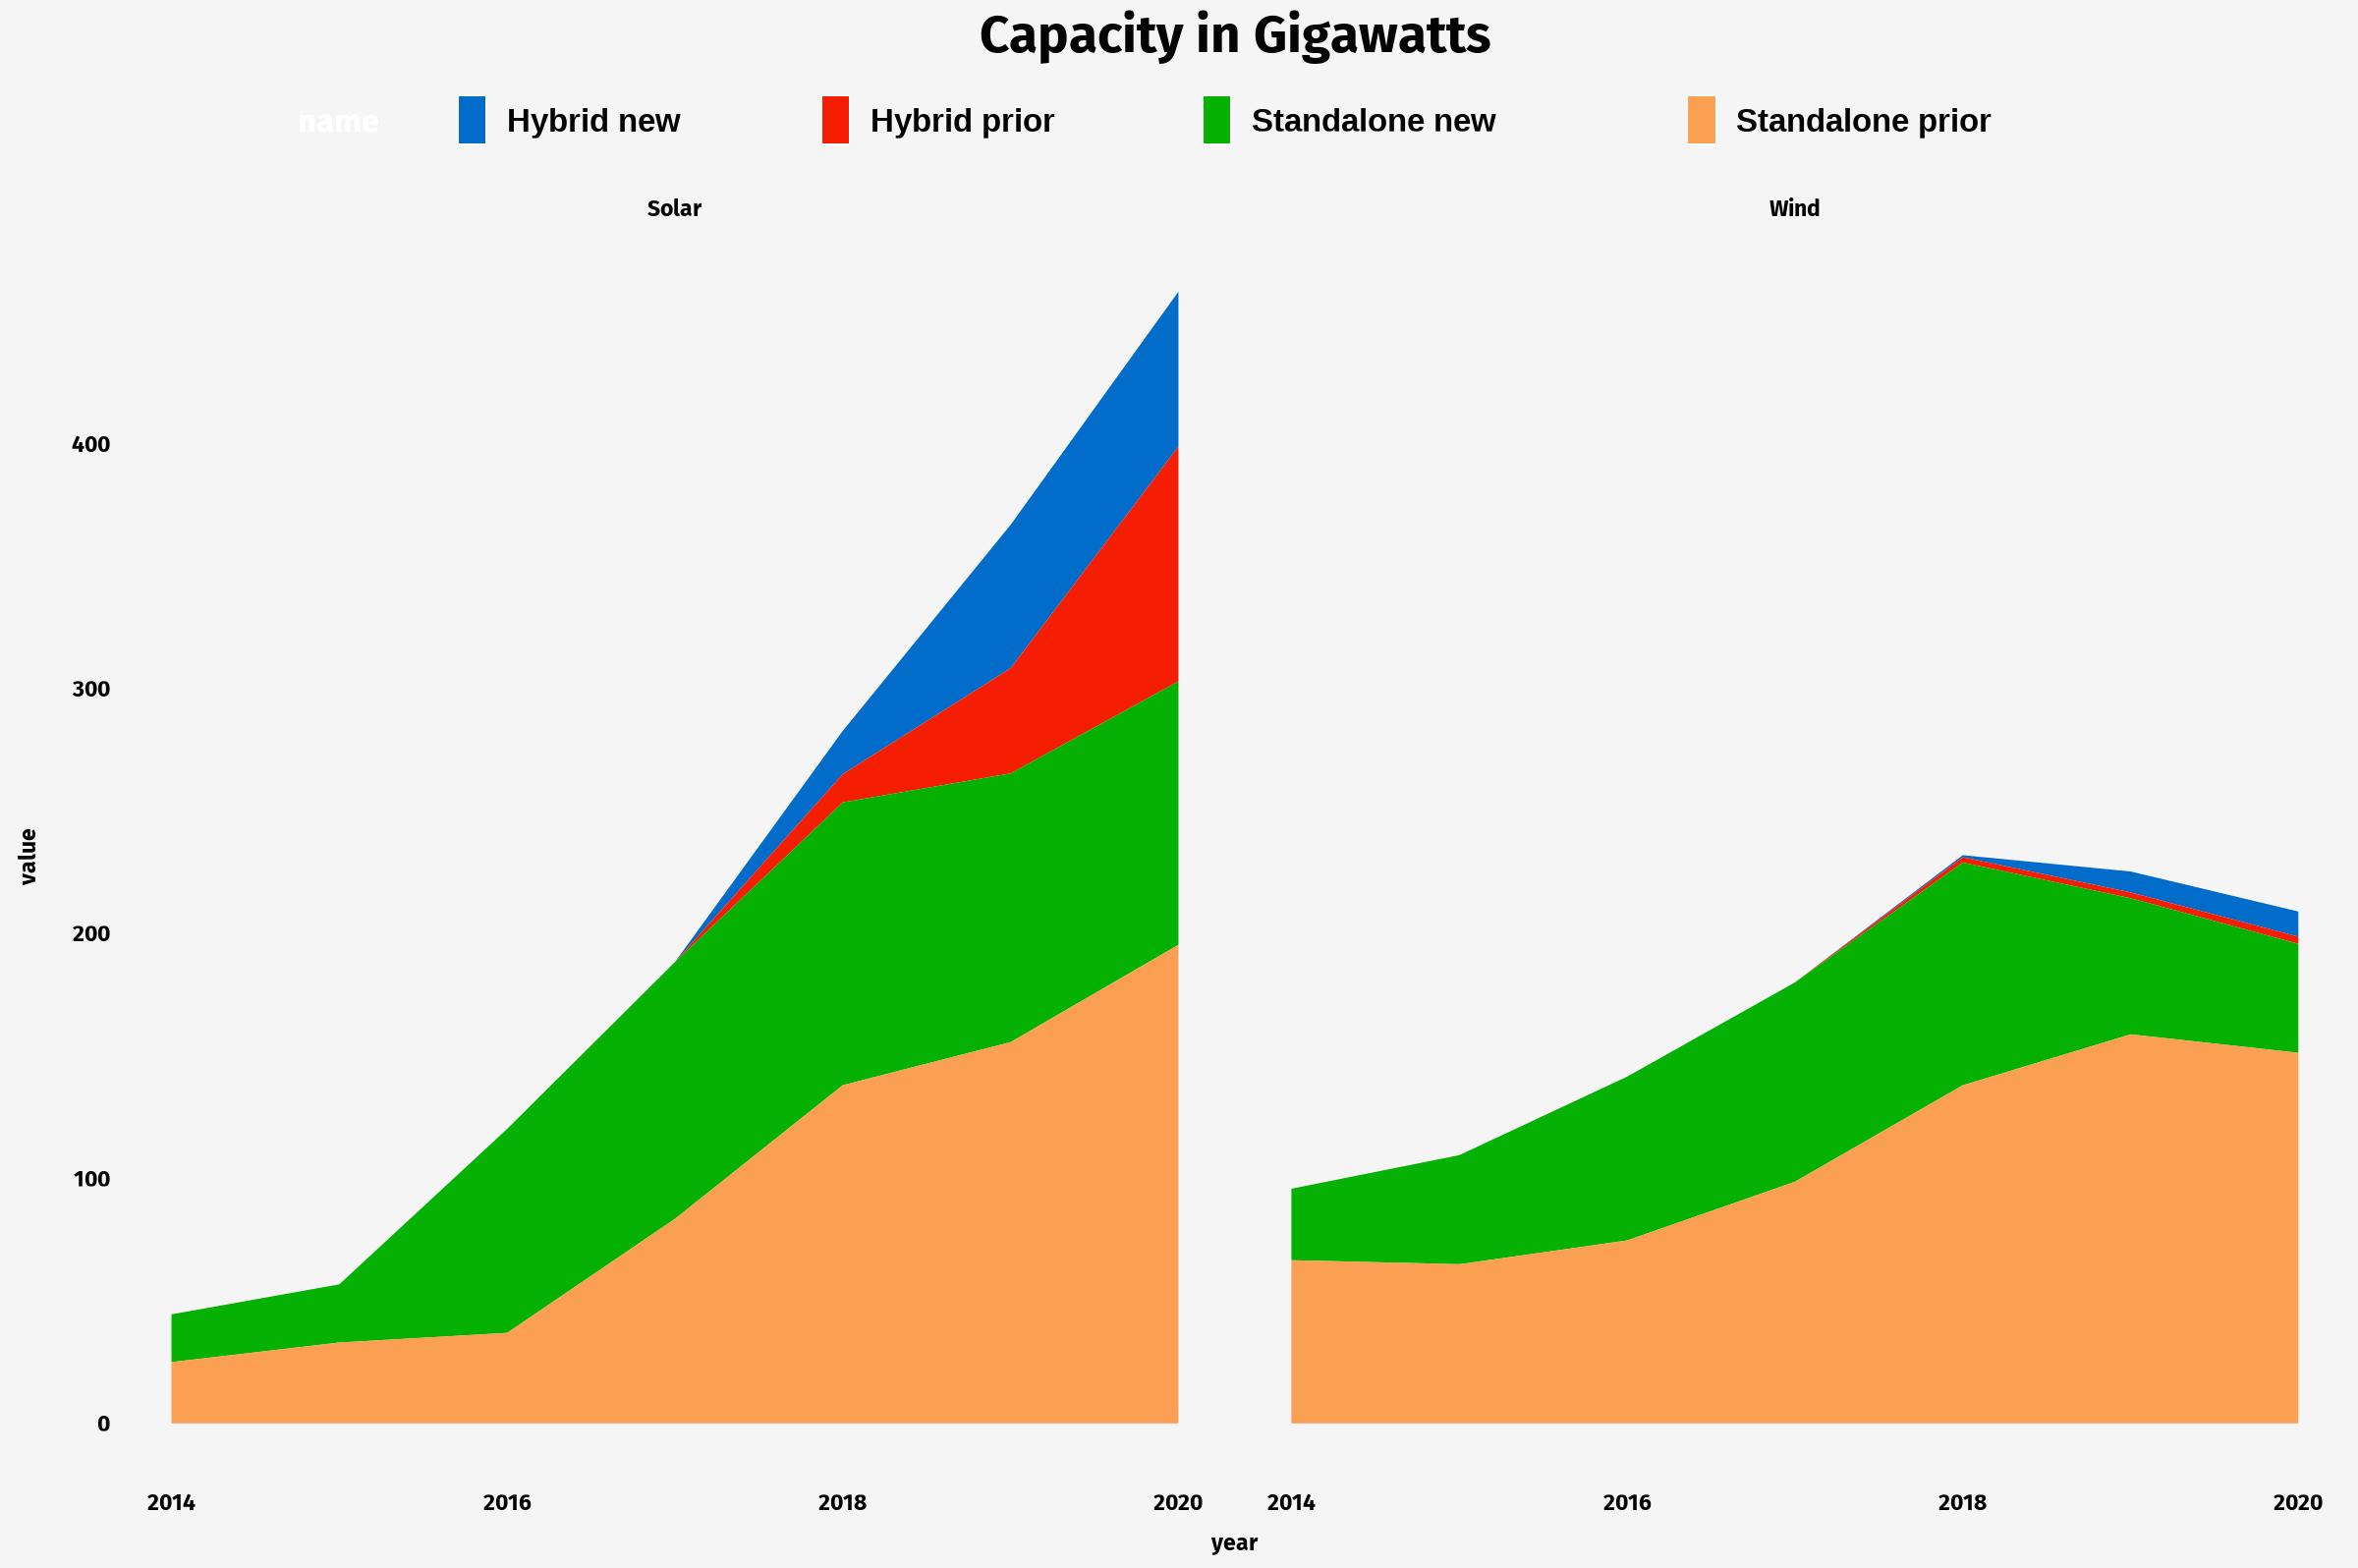

In [6]:
p1 = capacity %>%
  rename("Standalone prior"=standalone_prior,
         "Hybrid prior" =hybrid_prior,
         "Standalone new" =standalone_new,
         "Hybrid new" =hybrid_new,) %>%
  pivot_longer(3:6) %>%
  filter(type=="Solar" | type=="Wind") %>%
   ggplot( aes(x=year, y=value, fill=name, text=name)) +
    geom_area( )  +
  scale_fill_paletteer_d("yarrr::xmen") +
  facet_wrap(~type)+
  labs(title = "Capacity in Gigawatts")+
  my_theme()
p1

## 1.2 Total Capacity of Energy in Gigawatts

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


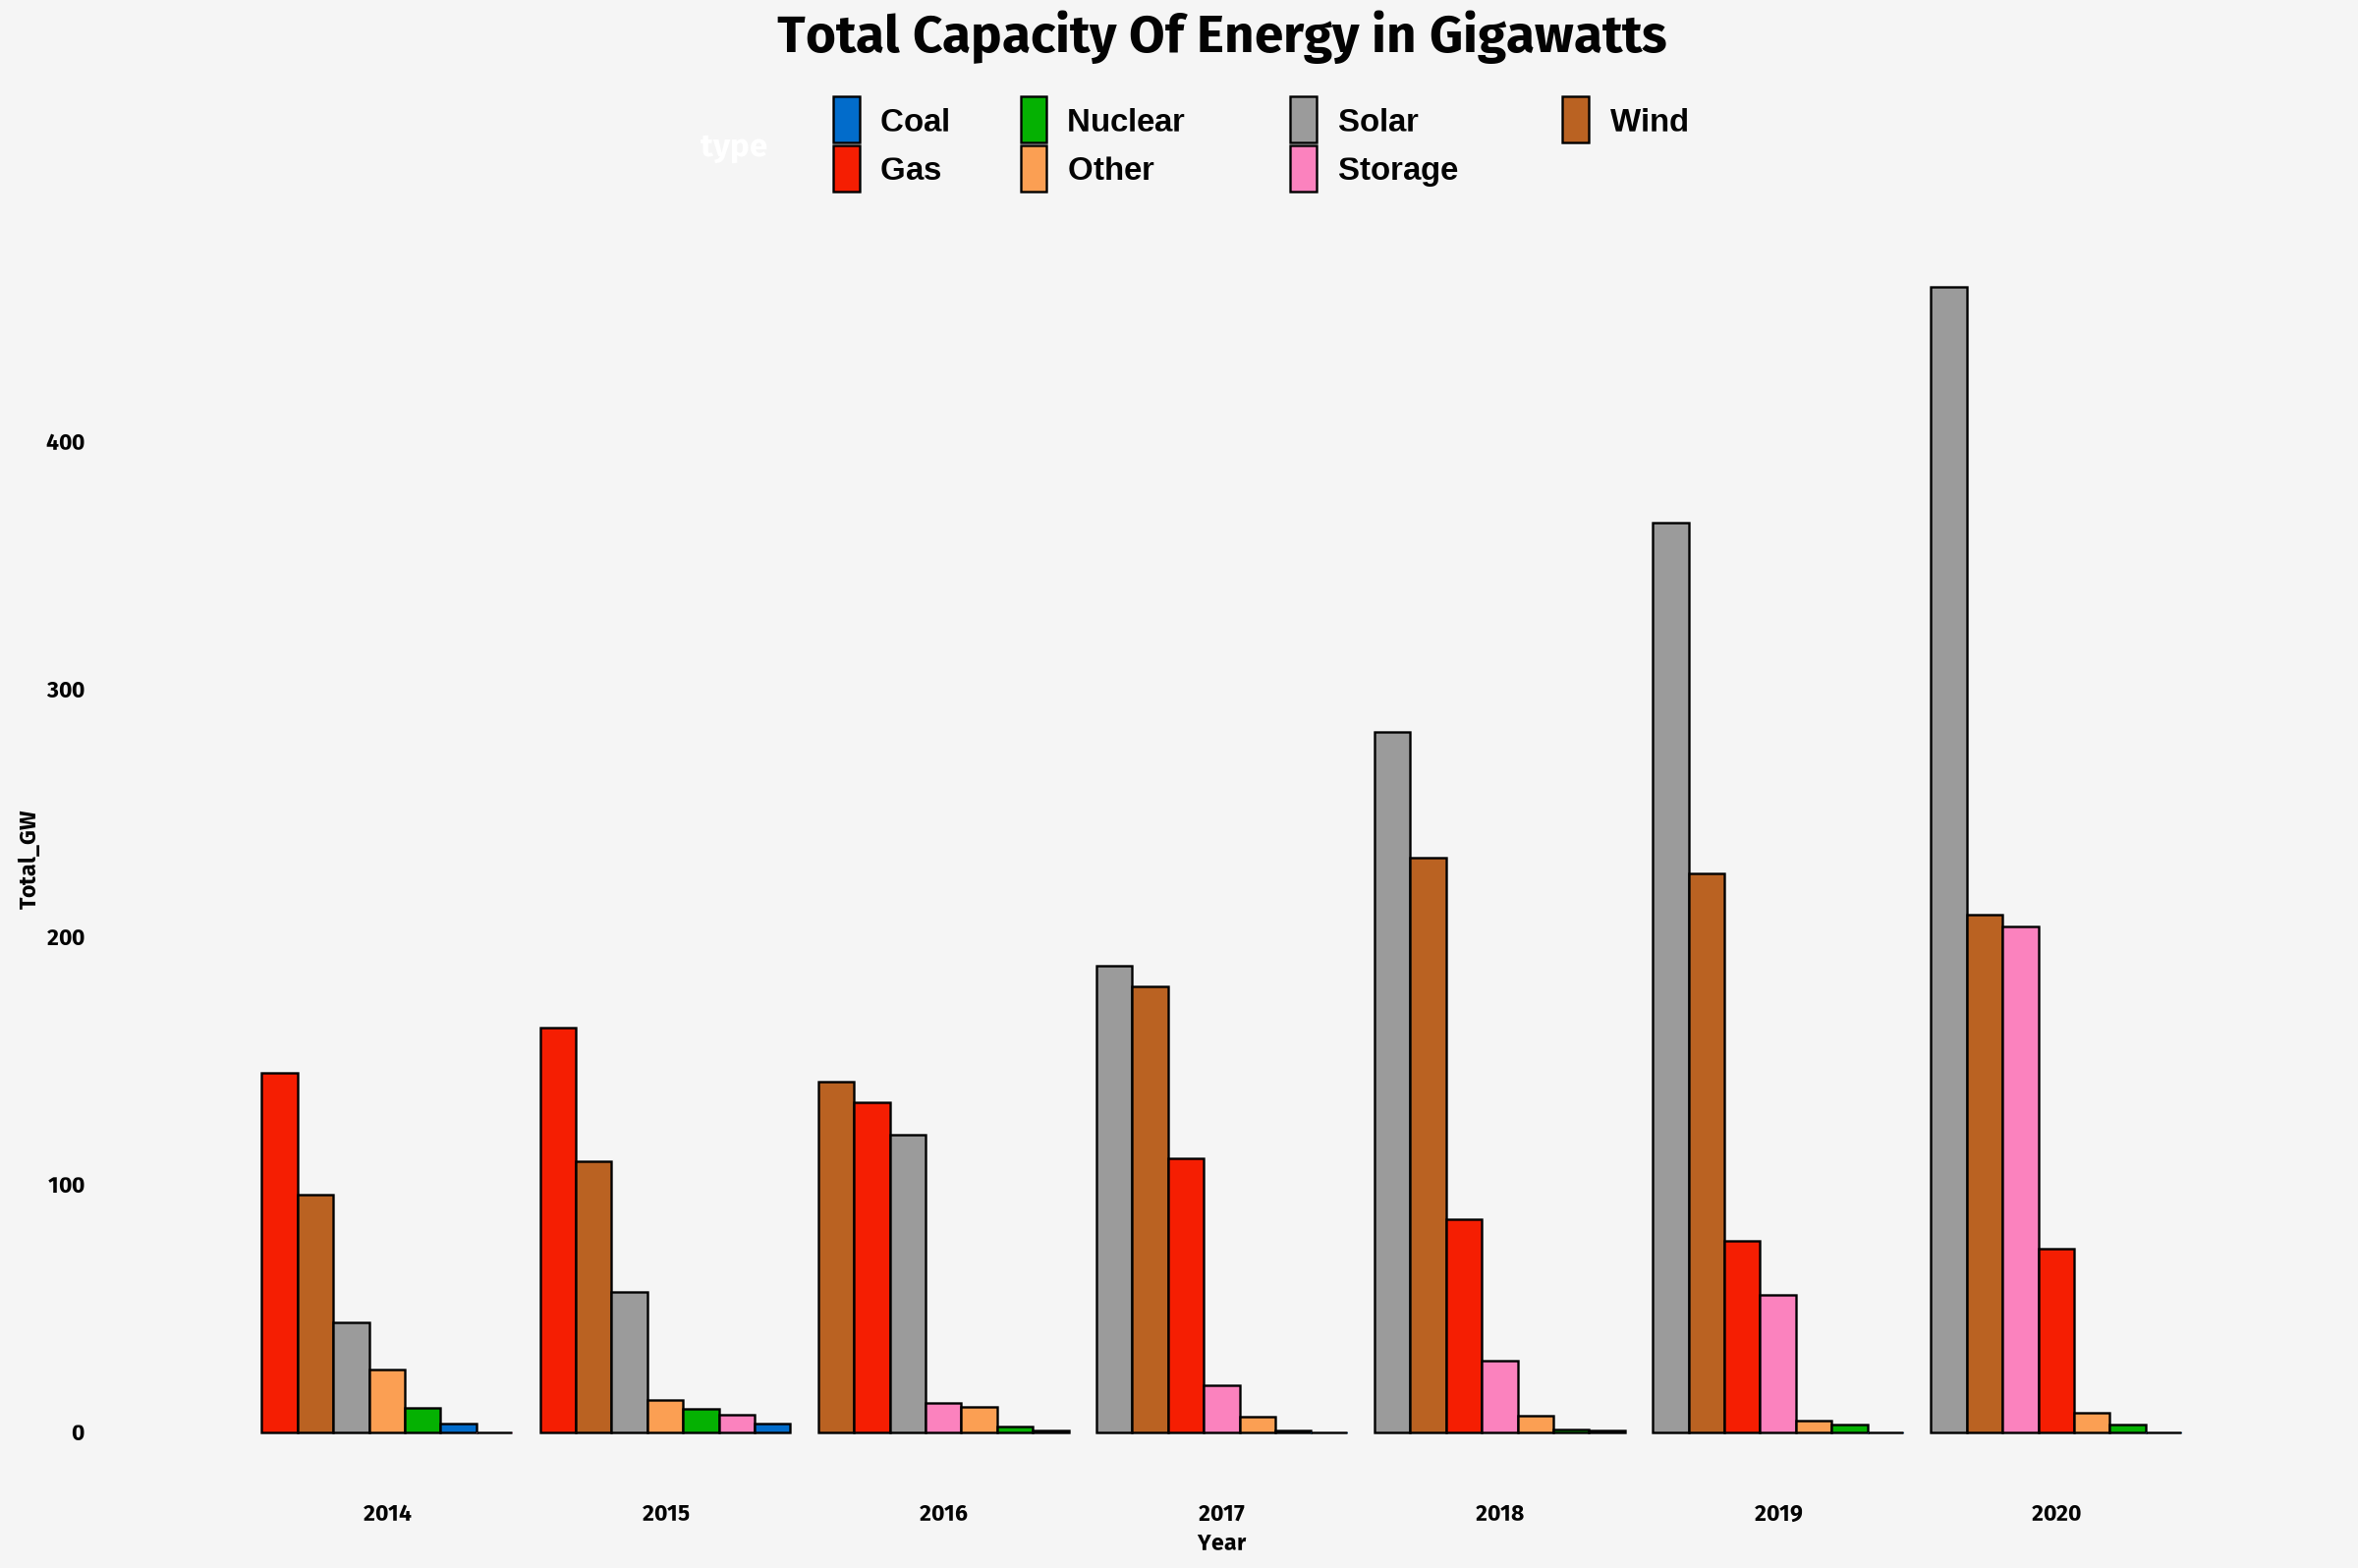

In [7]:
p2 <- capacity %>%
  mutate(type2 = tidytext::reorder_within(type, -total_gw, within = year))%>%
  ggplot(aes(x = year, weight = total_gw, fill = type, colour = type)) +
  geom_bar(position = "dodge", aes(group = type2),color = "black") +
  scale_x_discrete(limits = c(2014:2020))+
  scale_fill_paletteer_d("yarrr::xmen")+
  labs(title = "Total Capacity Of Energy in Gigawatts",
      x = "Year",
      y = "Total_GW",
      color = "Type\nof\npower:")+
  my_theme()
p2

# 2. Wind and Solar

In [8]:
head(wind)

date,wind_mwh,wind_capacity
<date>,<dbl>,<dbl>
2009-01-28,54.09669,50.4
2009-01-30,62.32682,98.9
2009-02-02,52.53105,99.0
2009-02-05,93.79017,150.0
2009-02-05,96.54664,51.0
2009-02-05,96.54664,49.5


In [9]:
head(solar)

date,solar_mwh,solar_capacity
<date>,<dbl>,<dbl>
2009-02-23,132.0968,30.0
2009-03-01,159.5024,30.0
2009-03-05,150.7604,19.0
2009-05-01,210.0705,12.6
2009-05-08,142.7834,230.0
2009-06-01,131.3547,20.0


In [10]:
w1 = wind %>% 
rename("Wind projected price in $/MWh"=wind_mwh, "Wind projected capacity in Gigawatts"=wind_capacity) %>% 
pivot_longer(2:3) %>% 
mutate(grp="Wind")


s1 = solar %>% 
rename("Solar projected price in $/MWh"=solar_mwh, "Solar projected capacity in Gigawatts"=solar_capacity) %>% 
pivot_longer(2:3) %>% 
mutate(grp="Solar")

## 2.1 Wind Projected Price and Capacity

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



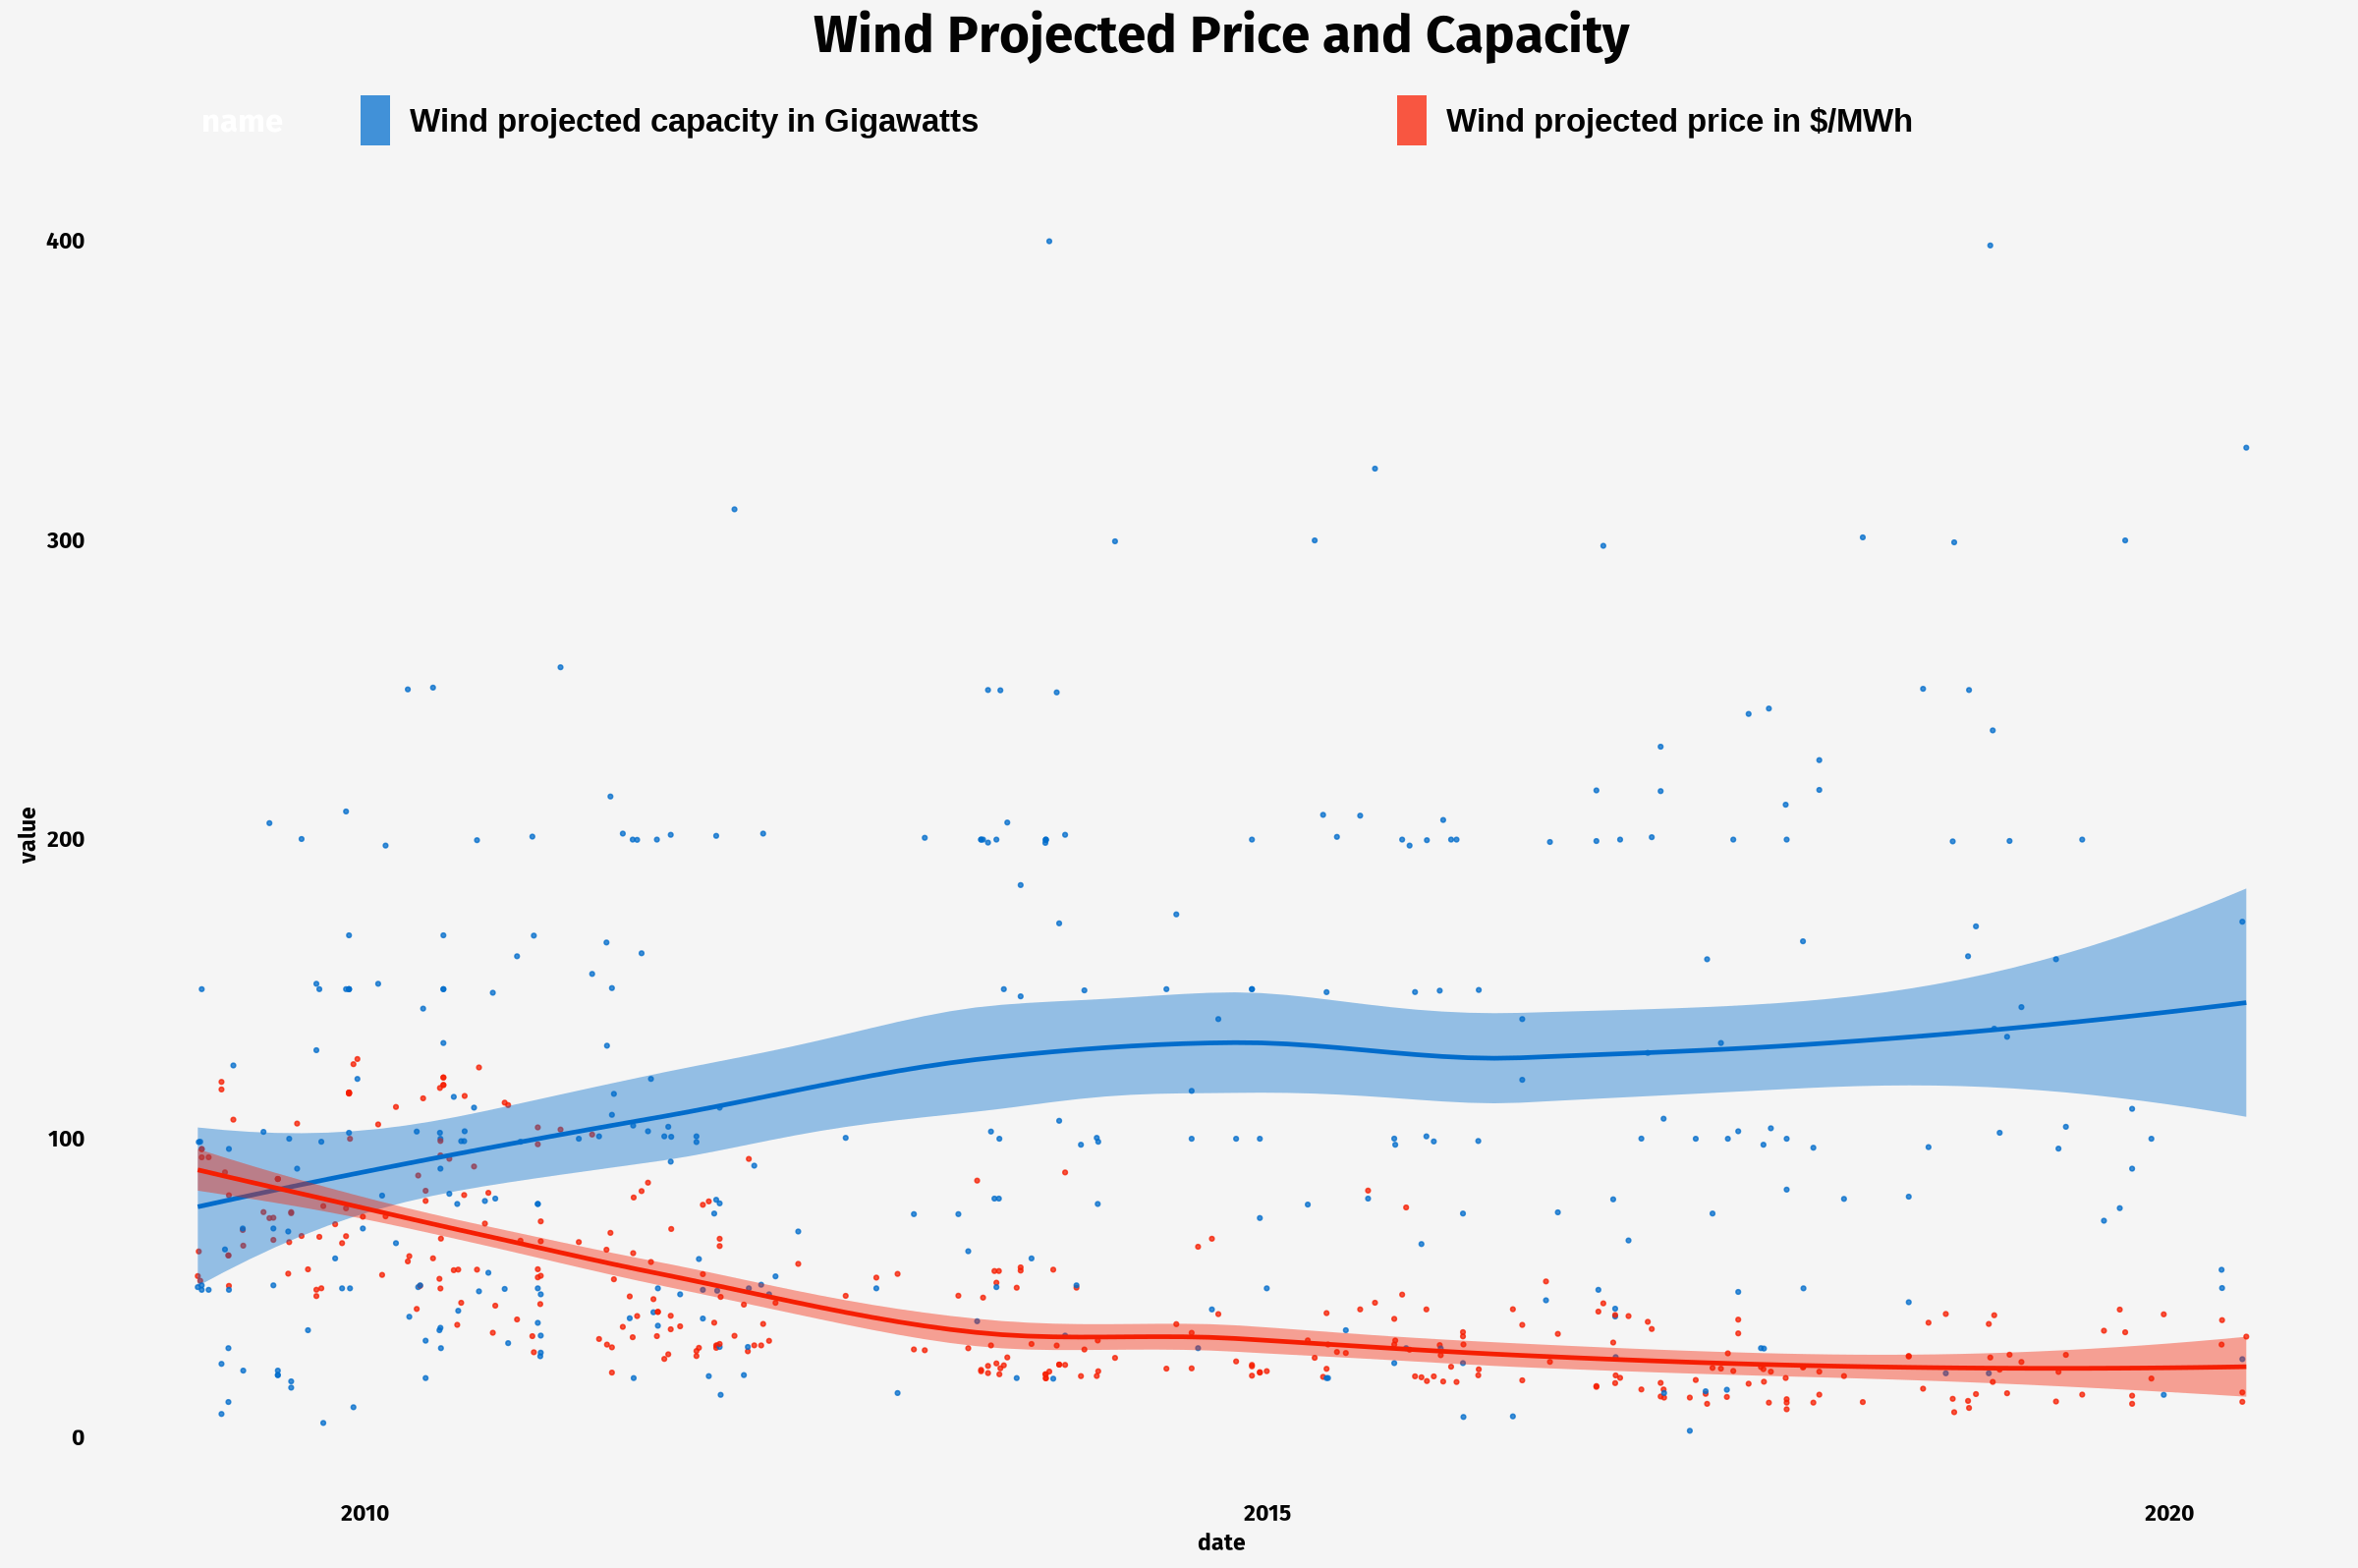

In [11]:
p3 =w1 %>%
  ggplot(aes(x=date, y=value, color=name, fill=name)) +
  geom_point(shape=21, size=.7, key_glyph = draw_key_rect, alpha=.75) +
  geom_smooth(show.legend=F)+
  scale_color_paletteer_d("yarrr::xmen")+
  scale_fill_paletteer_d("yarrr::xmen")+
  labs(title = "Wind Projected Price and Capacity")+
  my_theme()
p3

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



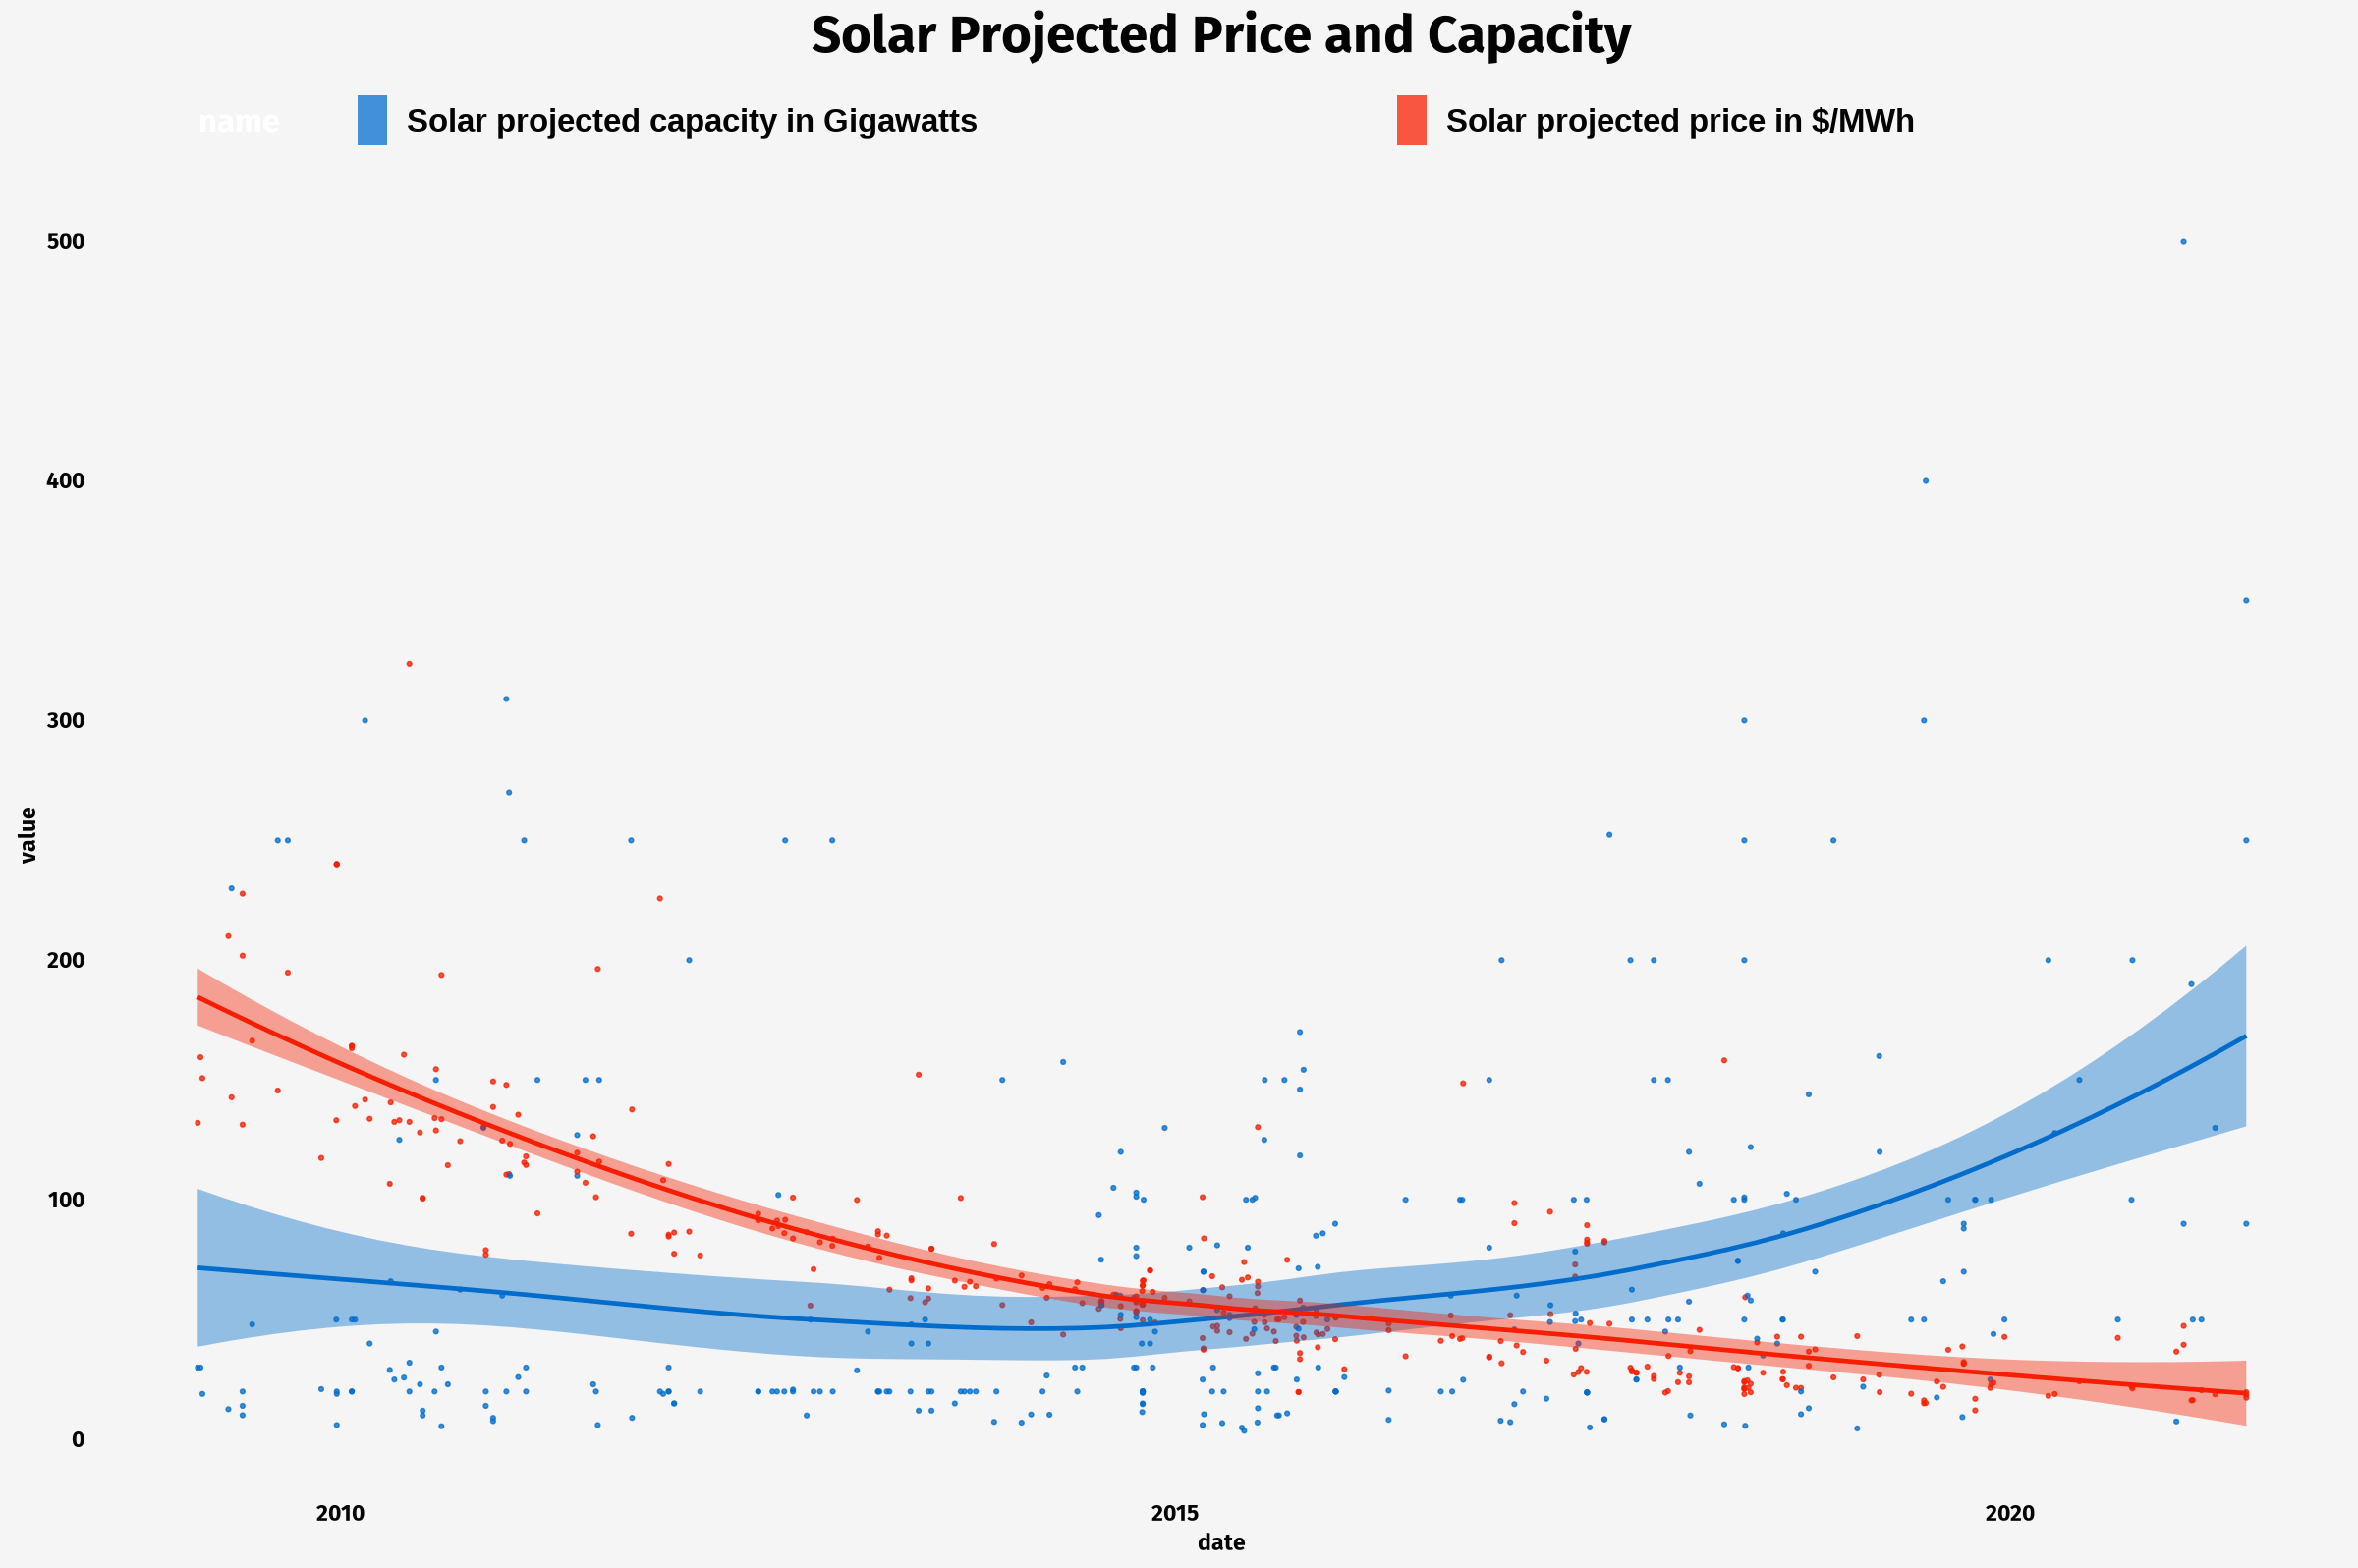

In [12]:
p4 =s1 %>%
  ggplot(aes(x=date, y=value, color=name, fill=name)) +
  geom_point(shape=21, size=.7, key_glyph = draw_key_rect, alpha=.75) +
  geom_smooth(show.legend=F)+
  scale_color_paletteer_d("yarrr::xmen")+
  scale_fill_paletteer_d("yarrr::xmen")+
  labs(title = "Solar Projected Price and Capacity")+
  my_theme()
p4

# 3. Average Cost

In [13]:
head(average_cost)

year,gas_mwh,solar_mwh,wind_mwh
<dbl>,<dbl>,<dbl>,<dbl>
2009,57.64537,167.66505,74.32525
2010,56.83171,139.80224,65.50134
2011,46.00009,110.85504,47.77625
2012,44.48750,84.09578,40.11423
2013,43.17249,68.88197,28.72295
2014,46.08092,57.27135,26.57614


In [14]:
average_cost <- melt(average_cost ,  id.vars = 'year', variable.name = 'series')

## 3.1 Average Cost for Each Type Of Power in Dollers per Megawatts

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


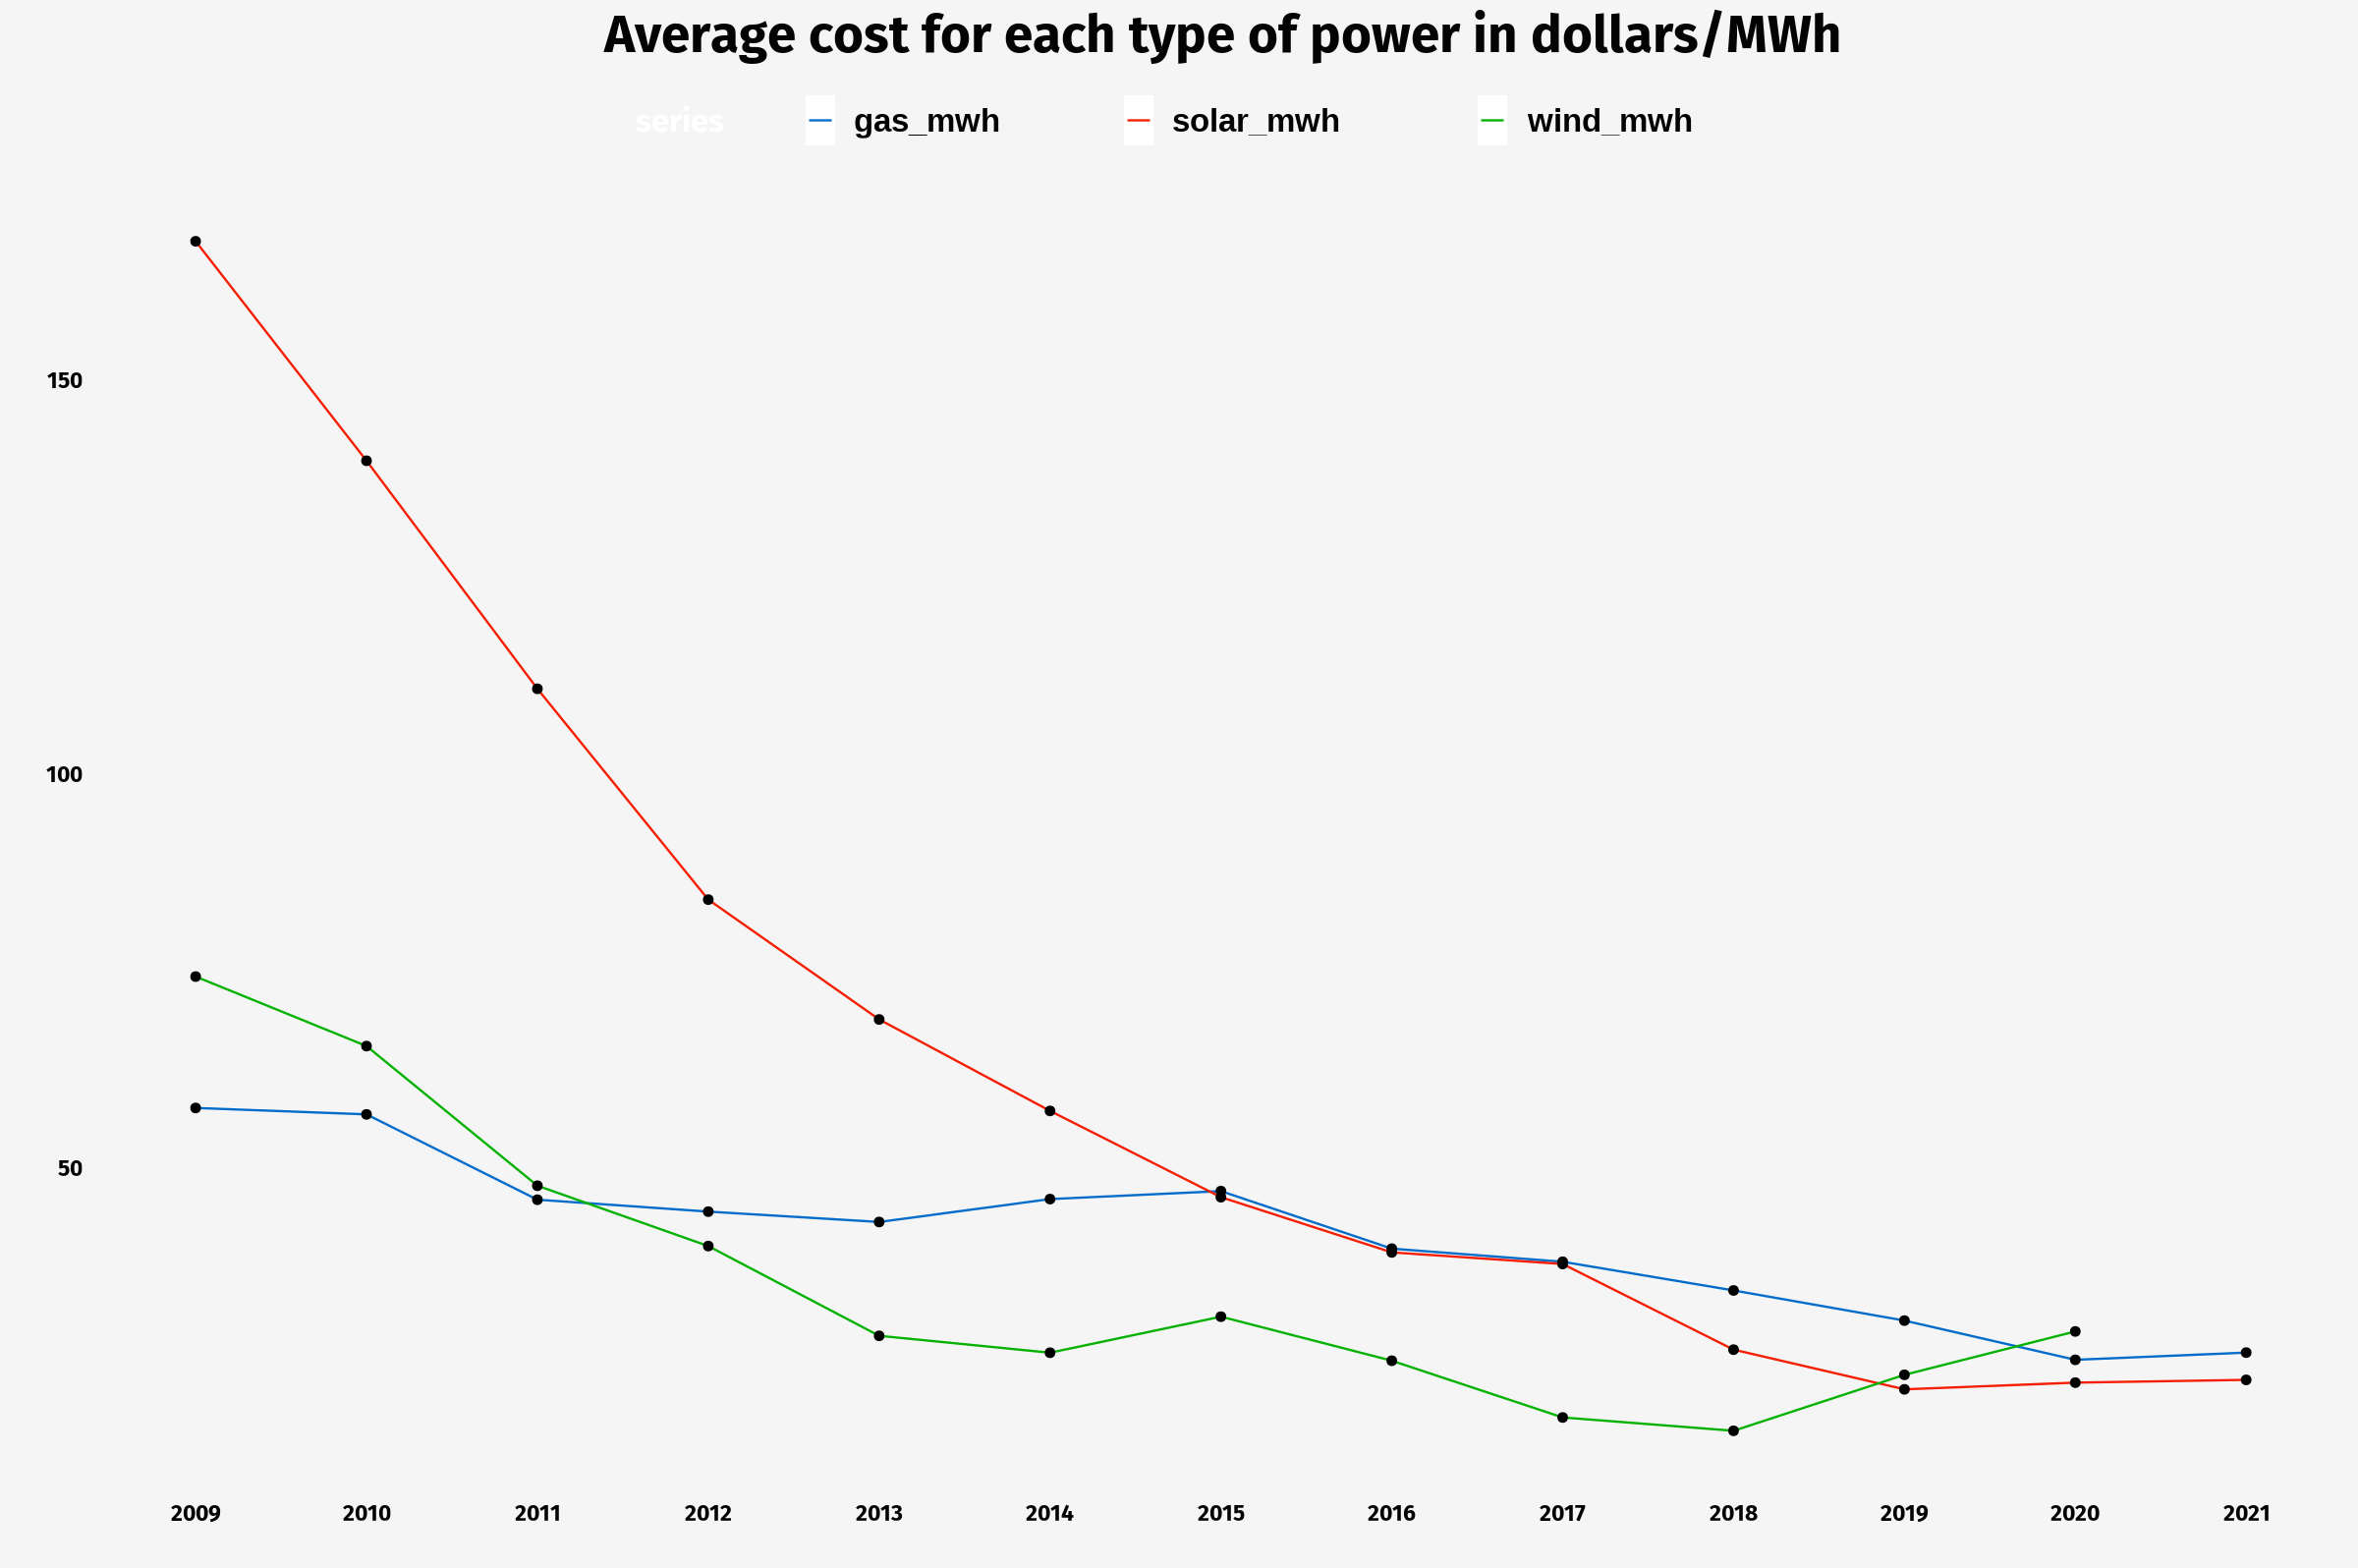

In [15]:
p5 <- ggplot(average_cost, aes(year, value)) +
  geom_line(aes(colour = series))+
  geom_point(color = "black", size = 2)+
  scale_x_discrete(limits = c(2009:2021))+
  scale_color_paletteer_d("yarrr::xmen")+
  labs(title = "Average cost for each type of power in dollars/MWh",
      x = "",
      y = "",
      )+
  my_theme()
p5